## Importing

In [6]:
from utils.utils import *
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN
import sympytorch


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Utils

In [7]:
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE
from train_and_eval import eval_model
from datasets.SyntheticData import SyntheticData
from sympy import symbols, sin, summation, simplify
import networkx as nx
from torch_geometric.utils import from_networkx
from utils.utils import integrate
from torch_geometric.data import Data
from experiments.experiments_mpnn import activations
from models.utils.MLP import MLP

In [8]:
from torch.utils.data import DataLoader


def get_model(g, h, message_passing=True, include_time=False, atol=1e-5, rtol=1e-3, integration_method = 'scipy_solver'):
    conv = MPNN(
        g_net = g,
        h_net = h, 
        message_passing=message_passing,
        include_time=include_time
    )
    
    symb = MPNN_ODE(
        conv=conv,
        model_path="./saved_models_optuna/tmp_symb",
        adjoint=True,
        integration_method=integration_method,
        atol=atol,
        rtol=rtol
    )
    
    return symb


def get_symb_test_error(g_symb, h_symb, test_set, message_passing=False, include_time=False, atol=1e-5, rtol=1e-3, scaler = None, inverse_scale=False, method='scipy_solver'):
    
    symb = get_model(
        g=g_symb,
        h=h_symb,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        integration_method=method
    )
    
    collate_fn = lambda samples_list: samples_list
    test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True, collate_fn=collate_fn)
    
    test_loss = eval_model(
        model=symb,
        valid_loader=test_loader,
        criterion=torch.nn.L1Loss(),
        scaler=scaler,
        inverse_scale=inverse_scale,
        pred_deriv=False
    )
    
    return test_loss


def get_test_set(dynamics, seed=12345, device='cuda', input_range = (0, 1), **integration_kwargs):
    graph = nx.barabasi_albert_graph(100, 3, seed=seed)
    edge_index = from_networkx(graph).edge_index
    edge_index = edge_index.to(torch.device(device))
    rng = np.random.default_rng(seed=seed)
    
    data, t = integrate(
        input_range=input_range,
        t_span = [0, 1],
        t_eval_steps=300,
        dynamics=dynamics,
        device=device,
        graph=graph,
        rng = rng,
        **integration_kwargs
    )
    
    snapshot = Data(
        x = data[0].unsqueeze(0),
        y = data[1:],
        edge_index=edge_index,
        edge_attr=None,
        t_span = t
    )
    
    return [snapshot]


def build_model_from_file(model_path, message_passing=False, include_time=False, method='dopri5', adjoint=True):
    best_params_file = f"{model_path}/best_params.json"
    best_state_path = f"{model_path}/mpnn/state_dict.pth"
    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)
    
    in_dim = 1
    
    hidden_layers = [best_hyperparams["hidden_dims_g_net"] for _ in range(best_hyperparams["n_hidden_layers_g_net"])]
    hidden_layers = [2*in_dim] + hidden_layers + [in_dim]    
    # g_net
    g_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_g_net']],
        dropout_rate=best_hyperparams['drop_p_g_net'],
    )
    
    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim
    hidden_layers = [best_hyperparams["hidden_dims_h_net"] for _ in range(best_hyperparams["n_hidden_layers_h_net"])]
    hidden_layers = [in_dim_h] + hidden_layers + [in_dim] 
    
    
    # h_net
    h_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_h_net']],
        dropout_rate=best_hyperparams['drop_p_h_net'],
    )
    
    mpnn = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time
    )
    
    model = MPNN_ODE(
        conv=mpnn,
        model_path='./saved_models_optuna/tmp',
        integration_method=method,
        adjoint=adjoint
    )
    
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False, map_location=torch.device('cuda')))
    
    return model


def plot_predictions(y_true, y_pred, node_index = 0):
    plt.figure(figsize=(16, 8))
    plt.plot(y_true[:, node_index, :], label='y_true', marker='o')
    plt.plot(y_pred[:, node_index, :], label='y_pred', marker='o')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f'y_true vs y_pred for Node {node_index}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

def post_process_mpnn(
    g_symb, 
    h_symb, 
    model_path, 
    test_set, 
    message_passing=False, 
    include_time=False,
    atol=1e-5,
    rtol=1e-3,
    method='dopri5',
    scaler=None,
    inverse_scale=False,
    adjoint=True 
):
    test_loss_symb = get_symb_test_error(
        g_symb=g_symb,
        h_symb=h_symb,
        test_set=test_set,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        method=method,
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    print(f"Test loss of symbolic formula: {test_loss_symb}")
    
    # Loading best model
    best_model = build_model_from_file(
        model_path=model_path,
        message_passing=message_passing,
        include_time=include_time,
        method=method,
        adjoint=adjoint
    )
    
    tot_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
    print(f"Number of model's parameters: {tot_params}")
    
    best_model = best_model.eval()
    test_loss_model = get_symb_test_error(
        g_symb=best_model.conv.model.g_net,
        h_symb=best_model.conv.model.h_net,
        test_set=test_set,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        method=method,
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    print(f"Test loss best model: {test_loss_model}")

    y_true = test_set[0].y.detach().cpu().numpy()
    y_pred = best_model(snapshot = test_set[0]).detach().cpu().numpy()
    
    return y_true, y_pred
    

def make_callable(expr):
    free_syms = expr.free_symbols
    if not free_syms:
        # Expression is constant
        const_value = float(expr)
        return lambda x: torch.full((x.shape[0], 1), const_value, dtype=x.dtype, device=x.device)

    sym_module = sympytorch.SymPyModule(expressions=[expr])
    syms = {str(s) for s in free_syms}
    if {'x_i', 'x_j'} <= syms:
        return lambda x: sym_module(x_i=x[:, 0], x_j=x[:, 1])
    elif 'x_i' in syms:
        return lambda x: sym_module(x_i=x[:, 0])
    elif 'x_j' in syms:
        return lambda x: sym_module(x_j=x[:, 1])
    else:
        raise ValueError(f"Unexpected symbols in expression: {free_syms}")
    

## LB Losses

### Kuramoto

In [4]:
kur_config = load_config("./configs/config_pred_deriv/config_ic1/config_kuramoto.yml")

KUR = get_test_set(
    dynamics=kur_config['name'],
    seed = 12345,
    device='cuda',
    input_range=kur_config['input_range'],
    **kur_config['integration_kwargs']    
)

g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5 * x[:, 1].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Kuramoto: {test_loss}")


/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Kuramoto: 0.0014357954496517777


### Epidemics

In [5]:
epid_config = load_config("./configs/config_pred_deriv/config_ic1/config_epidemics.yml")

EPID = get_test_set(
    dynamics=epid_config['name'],
    seed = 12345,
    device='cuda',
    input_range=epid_config['input_range'],
    **epid_config['integration_kwargs']    
)

g_symb = lambda x: 0.5*x[:, 1].unsqueeze(-1) * (1 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.5 * x[:, 0].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=EPID,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Epidemics: {test_loss}")


Epidemics: 3.470474621281028e-05


### Biochemical

In [6]:
bio_config = load_config("./configs/config_pred_deriv/config_ic1/config_biochemical.yml")

BIO = get_test_set(
    dynamics=bio_config['name'],
    seed = 12345,
    device='cuda',
    input_range=bio_config['input_range'],
    **bio_config['integration_kwargs']    
)

g_symb = lambda x: (-0.5*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: (1.0 - 0.5 * x[:, 0]).unsqueeze(-1)  + x[:, 1].unsqueeze(-1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Biochemical: {test_loss}")

Biochemical: 2.9267064746818505e-05


### Population

In [7]:
pop_config = load_config("./configs/config_pred_deriv/config_ic1/config_population.yml")

POP = get_test_set(
    dynamics=pop_config['name'],
    seed = 12345,
    device='cuda',
    input_range=pop_config['input_range'],
    **pop_config['integration_kwargs']    
)

g_symb = lambda x: 0.2*torch.pow(x[:, 1].unsqueeze(-1), 3)
h_symb = lambda x: -0.5 * x[:, 0].unsqueeze(-1) + x[:, 1].unsqueeze(1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=POP,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Population: {test_loss}")


Population: 5.318017429090105e-05


### Kuramoto MPNN

#### IC=1

In [9]:
model_path_mpnn = './saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_6/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

In [11]:
mpnn_symb[0]

\sum_{j}( -0.496255922752406*sin(x_i - x_j)) - 0.00359839429571021*Abs(log(x_i)) + 2.00352225227241

In [12]:
quantise(mpnn_symb[0])

\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0

In [11]:
g_symb = lambda x: -0.48802644*torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 1.010286 + x[:, 1].unsqueeze(-1) + torch.tanh( torch.exp(x[:, 0].unsqueeze(-1)))

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_kuramoto_mpnn/kuramoto_mpnn_ic1_s5/2',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.00990354921668768
Number of model's parameters: 4298
Test loss best model: 0.024828754365444183


#### IC=3

In [12]:
model_path_mpnn = './saved_models/mpnn/model_kuramoto_mpnn/kuramoto_mpnn_ic3_s5/1/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [13]:
mpnn_symb

\sum_{j}( -0.4950775*sin(x_i - x_j)) + 1.99961297633177*exp(0.004879089*sin(x_i))

In [14]:
quantise(mpnn_symb)

\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0

In [15]:
g_symb = lambda x: -0.4950775*torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) + 1.99961297633177 * torch.exp(0.004879089*torch.sin(x[:, 0].unsqueeze(-1)))


y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_kuramoto_mpnn/kuramoto_mpnn_ic3_s5/1',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.004990159533917904
Number of model's parameters: 3466
Test loss best model: 0.005056753288954496


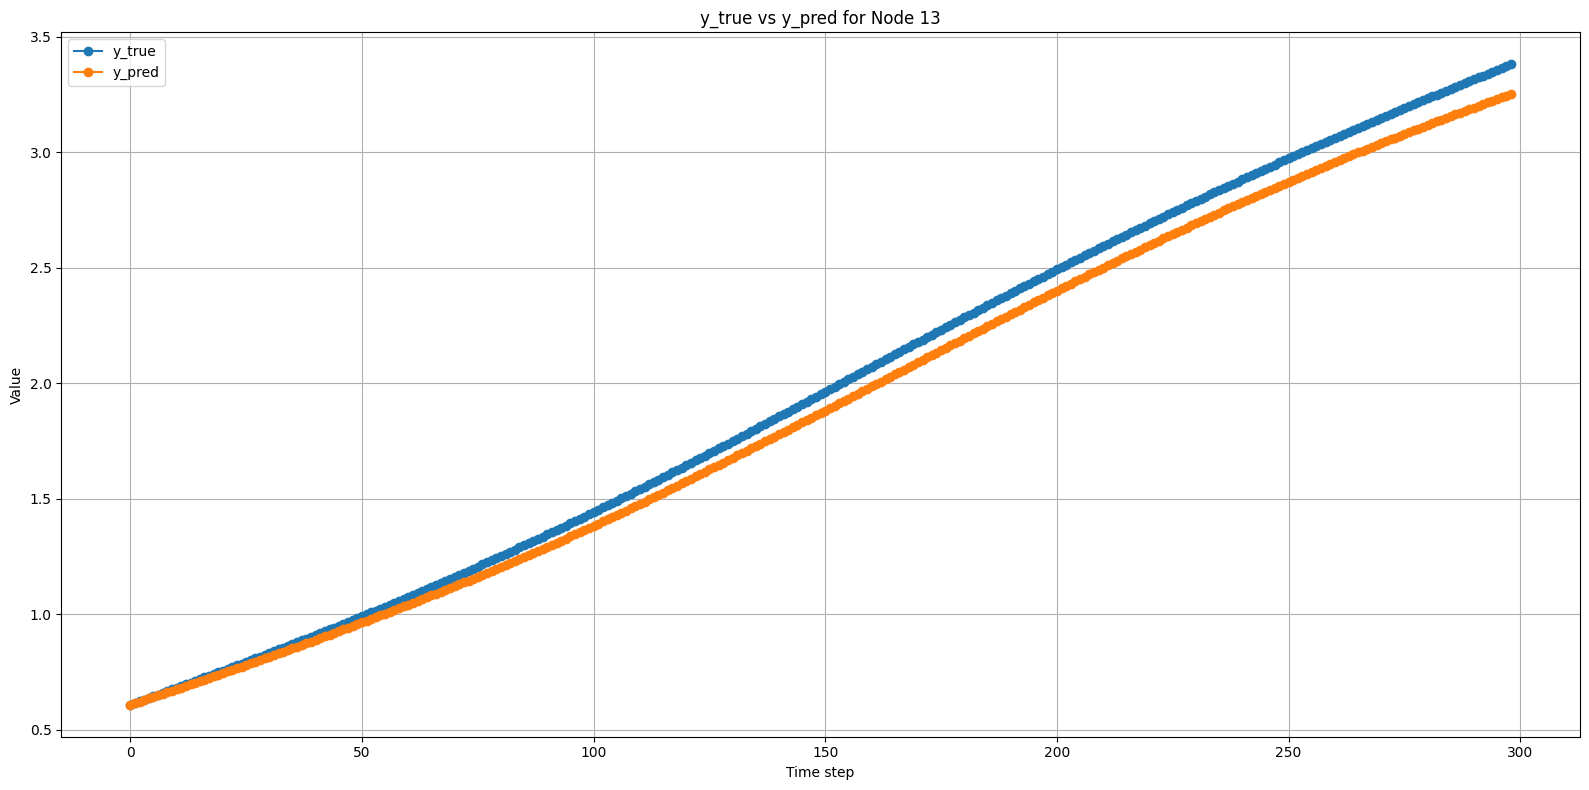

In [21]:
plot_predictions(y_true, y_pred, node_index=13)

#### IC=5

In [17]:
model_path_mpnn = './saved_models/mpnn/model_kuramoto_mpnn/kuramoto_mpnn_ic5_s5/2/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [18]:
mpnn_symb

\sum_{j}( -0.49897763*sin(x_i - x_j)) + 8.437033e-6*exp(re(x_i)) + 1.9998884

In [19]:
quantise(mpnn_symb)

\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0

In [76]:
g_symb = lambda x: -0.49897763*torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 1.9998884 + x[:, 1].unsqueeze(-1) + 8.437033 * 10e-7 * torch.exp(x[:, 0].unsqueeze(-1))


y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_kuramoto_mpnn/kuramoto_mpnn_ic5_s5/2',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0016100124921649694
Number of model's parameters: 5570
Test loss best model: 0.004750935826450586


### Epidemics MPNN

#### IC=1

In [21]:
model_path_mpnn = './saved_models/mpnn/model_epidemics_mpnn/epidemics_mpnn_ic1_s5/1/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [22]:
mpnn_symb

\sum_{j}( x_j*(0.49561933 - 0.49533916*x_i)) - 0.6944137*tanh(x_i) + 0.06518038

In [23]:
quantise(mpnn_symb)

\sum_{j}(x_j*(0.5 - 0.5*x_i)) - 0.69*tanh(x_i) + 0.07

In [29]:
g_symb = lambda x: x[:, 1].unsqueeze(-1) * (0.49561933 - 0.49533916 * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.6944137 * torch.tanh(x[:, 0].unsqueeze(-1)) + 0.06518038

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_epidemics_mpnn/epidemics_mpnn_ic1_s5/1',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.002190784551203251
Number of model's parameters: 5178
Test loss best model: 0.001356420572847128


#### IC=3

In [25]:
model_path_mpnn = './saved_models/mpnn/model_epidemics_mpnn/epidemics_mpnn_ic3_s5/2/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [26]:
mpnn_symb

\sum_{j}( -0.5012283*x_j*(x_i - 0.99863404)) - 0.49647868*x_i

In [27]:
quantise(mpnn_symb)

\sum_{j}(-0.5*x_j*(x_i - 1.0)) - 0.5*x_i

In [28]:
g_symb = lambda x: -0.5012283*x[:, 1].unsqueeze(-1) * (x[:, 0] - 0.99863404).unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.49647868 * x[:, 0].unsqueeze(-1)

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_epidemics_mpnn/epidemics_mpnn_ic3_s5/2',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.00043418907443992794
Number of model's parameters: 2594
Test loss best model: 0.00044093799078837037


#### IC=5

In [30]:
model_path_mpnn = './saved_models/mpnn/model_epidemics_mpnn/epidemics_mpnn_ic5_s5/2/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [31]:
mpnn_symb

\sum_{j}( -0.50012624*x_j*(x_i - 1.0000536)) - 0.5006757*x_i

In [32]:
quantise(mpnn_symb)

\sum_{j}(-0.5*x_j*(x_i - 1.0)) - 0.5*x_i

In [33]:
g_symb = lambda x: -0.50012624*x[:, 1].unsqueeze(-1) * (-1.0000536 + x[:, 0]).unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.5006757 * x[:, 0].unsqueeze(-1)

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_epidemics_mpnn/epidemics_mpnn_ic5_s5/2',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 8.796314068604261e-05
Number of model's parameters: 5042
Test loss best model: 0.0006304859416559339


### Neuronal MPNN

#### IC=1

In [34]:
model_path_mpnn = './saved_models/mpnn/model_neuronal_mpnn/neuronal_mpnn_ic1_s5/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [35]:
mpnn_symb

\sum_{j}( 0.290232*tanh(x_j)) - 0.16600157*x_i + 0.23117396

In [36]:
quantise(mpnn_symb)

\sum_{j}(0.29*tanh(x_j)) - 0.17*x_i + 0.23

In [37]:
g_symb = lambda x: 0.290232 * torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: -0.16600157 * x[:, 0].unsqueeze(-1) + x[:, 1].unsqueeze(-1) + 0.23117396

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_neuronal_mpnn/neuronal_mpnn_ic1_s5/0',
    test_set=NEUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0215381421148777
Number of model's parameters: 866
Test loss best model: 0.005497673526406288


#### IC=3

In [38]:
model_path_mpnn = "./saved_models/mpnn/model_neuronal_mpnn/neuronal_mpnn_ic3_s5/1/mpnn"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [39]:
mpnn_symb

\sum_{j}( 0.2963725*tanh(x_j)) - log(x_i + 1) + tanh(x_i)

In [40]:
quantise(mpnn_symb)

\sum_{j}(0.3*tanh(x_j)) - log(x_i + 1) + tanh(x_i)

In [41]:
g_symb = lambda x: 0.2963725 * torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - torch.log(x[:, 0].unsqueeze(-1) + 1) + torch.tanh(x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_neuronal_mpnn/neuronal_mpnn_ic3_s5/1',
    test_set=NEUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.032588619738817215
Number of model's parameters: 3698
Test loss best model: 0.0016864202916622162


#### IC=5

In [42]:
model_path_mpnn = './saved_models/mpnn/model_neuronal_mpnn/neuronal_mpnn_ic5_s5/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [43]:
mpnn_symb

\sum_{j}( 0.29917783*tanh(x_j)) - 0.503255079013815*x_i + tanh(log(x_i + 1))

In [44]:
quantise(mpnn_symb)

\sum_{j}(0.3*tanh(x_j)) - 0.5*x_i + tanh(log(x_i + 1))

In [71]:
g_symb = lambda x: 0.29917783 * torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: -0.503255079013815 * x[:, 0].unsqueeze(-1) + x[:, 1].unsqueeze(-1) + torch.tanh(torch.log(x[:, 0].unsqueeze(-1) + 1))

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_neuronal_mpnn/neuronal_mpnn_ic5_s5/0',
    test_set=NEUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.004651771858334541
Number of model's parameters: 418
Test loss best model: 0.0009217999177053571


### Biochemical MPNN

#### IC=3

In [46]:
model_path_mpnn = './saved_models/mpnn/model_biochemical_mpnn/biochemical_mpnn_ic3_s5/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [47]:
mpnn_symb

\sum_{j}( -0.4983484*x_i*x_j) + log(2.6209304 - x_i)

In [48]:
quantise(mpnn_symb)

\sum_{j}(-0.5*x_i*x_j) + log(2.62 - x_i)

In [49]:
g_symb = lambda x: - 0.4983484 * x[:, 0].unsqueeze(-1) * x[:,1].unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) + torch.log(2.6209304 - x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_biochemical_mpnn/biochemical_mpnn_ic3_s5/0',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0013972758315503597
Number of model's parameters: 506
Test loss best model: 0.0006739266682416201


#### IC=1

In [50]:
model_path_mpnn = './saved_models/mpnn/model_biochemical_mpnn/biochemical_mpnn_ic1_s5/1/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [53]:
mpnn_symb

\sum_{j}( -0.5009741*x_i*x_j) + log(2.6314088 - x_i)

In [54]:
quantise(mpnn_symb)

\sum_{j}(-0.5*x_i*x_j) + log(2.63 - x_i)

In [55]:
g_symb = lambda x: - 0.5009741 * x[:, 0].unsqueeze(-1) * x[:,1].unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) + torch.log(2.6314088 - x[:, 0].unsqueeze(-1))

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_biochemical_mpnn/biochemical_mpnn_ic1_s5/1',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0016533834859728813
Number of model's parameters: 5162
Test loss best model: 0.0010797070572152734


#### IC=5

In [56]:
model_path_mpnn = './saved_models/mpnn/model_biochemical_mpnn/biochemical_mpnn_ic5_s5/2/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [59]:
mpnn_symb

\sum_{j}( -0.5005382*x_i*x_j) + sin(tanh(x_i) + 1.8312566)

In [60]:
quantise(mpnn_symb)

\sum_{j}(-0.5*x_i*x_j) + sin(tanh(x_i) + 1.83)

In [61]:
g_symb = lambda x: - 0.5005382 * x[:, 0].unsqueeze(-1) * x[:,1].unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) + torch.sin(torch.tanh(x[:, 0].unsqueeze(-1)) + 1.8312566)

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_biochemical_mpnn/biochemical_mpnn_ic5_s5/2',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0005971380160190165
Number of model's parameters: 2570
Test loss best model: 0.0003442340821493417


### Population MPNN

#### IC=1

In [62]:
model_path_mpnn = "./saved_models/mpnn/model_population_mpnn/population_mpnn_ic1_s5/0/mpnn"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [63]:
mpnn_symb

\sum_{j}( 0.1949548*x_j**2) - 0.89237803*log(x_i + 1)**2

In [64]:
quantise(mpnn_symb)

\sum_{j}(0.19*x_j**2) - 0.89*log(x_i + 1)**2

In [65]:
g_symb = lambda x: 0.1949548 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.89237803 * torch.square(torch.log(x[:, 0].unsqueeze(-1) + 1))

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_population_mpnn/population_mpnn_ic1_s5/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.016310198232531548
Number of model's parameters: 2338
Test loss best model: 0.020823068916797638


#### IC=3

In [66]:
model_path_mpnn = "./saved_models/mpnn/model_population_mpnn/population_mpnn_ic3_s5/0/mpnn"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [67]:
mpnn_symb

\sum_{j}( 0.19598695557314*x_j**2) - log(x_i + 1)**2

In [68]:
quantise(mpnn_symb)

\sum_{j}(0.2*x_j**2) - log(x_i + 1)**2

In [69]:
g_symb = lambda x: 0.19598695557314 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - torch.square(torch.log(x[:, 0].unsqueeze(-1) + 1))

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_population_mpnn/population_mpnn_ic3_s5/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.026079153642058372
Number of model's parameters: 2690
Test loss best model: 0.0051714167930185795


#### IC=5

In [72]:
model_path_mpnn = "./saved_models/mpnn/model_population_mpnn/population_mpnn_ic5_s5/0/mpnn"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/rcappi/.conda/envs/my_env/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [73]:
mpnn_symb

\sum_{j}( 0.197697369388124*x_j**2) - sin(0.5081722*x_i**2)

In [74]:
quantise(mpnn_symb)

\sum_{j}(0.2*x_j**2) - sin(0.51*x_i**2)

In [75]:
g_symb = lambda x: 0.197697369388124 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - torch.sin(0.5081722* torch.square(x[:, 0].unsqueeze(-1)))

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models/mpnn/model_population_mpnn/population_mpnn_ic5_s5/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.010449079796671867
Number of model's parameters: 2618
Test loss best model: 0.002170089865103364


## Symb Reg


### Biochemical

#### IC=1

In [16]:
model_path_mpnn = './saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5_pd_mult_12/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb, symb_g, symb_h = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

In [17]:
mpnn_symb

\sum_{j}( -0.4989559*x_i*x_j) - 0.49701315*x_i + 0.9987079

In [18]:
g_symb = make_callable(symb_g)
h_symb = make_callable(symb_h)

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5_pd_mult_12/0',
    test_set=BIO,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0003540606121532619
Number of model's parameters: 2122
Test loss best model: 0.0004302817105781287


### Kuramoto

#### IC=1

In [19]:
model_path_mpnn = './saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_12/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb, symb_g, symb_h = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

In [20]:
mpnn_symb

\sum_{j}( -0.4971926*sin(x_i - x_j)) + 2.0009475

In [21]:
quantise(mpnn_symb)

\sum_{j}(-0.5*sin(x_i - x_j)) + 2.0

In [22]:
g_symb = make_callable(symb_g)
h_symb = make_callable(symb_h)

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5_pd_mult_12/0',
    test_set=KUR,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0023325488436967134
Number of model's parameters: 3514
Test loss best model: 0.0057465676218271255


### Epidemics

#### IC=1

In [23]:
model_path_mpnn = './saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5_pd_mult_12/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb, symb_g, symb_h = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

In [24]:
mpnn_symb

\sum_{j}( x_j*(0.49643058 - 0.49589118*x_i)) - 0.49904868*x_i

In [25]:
g_symb = make_callable(symb_g)
h_symb = make_callable(symb_h)

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5_pd_mult_12/0',
    test_set=EPID,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.0009158015018329024
Number of model's parameters: 5090
Test loss best model: 0.0006920205196365714


### Population

#### IC=1

In [26]:
model_path_mpnn = './saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5_pd_mult_12/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb, symb_g, symb_h = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=10000,
    message_passing=False
)

In [27]:
mpnn_symb

\sum_{j}( 0.197325724628776*x_j**3) - 0.49980032*x_i

In [28]:
quantise(mpnn_symb)

\sum_{j}(0.2*x_j**3) - 0.5*x_i

In [29]:
g_symb = make_callable(symb_g)
h_symb = make_callable(symb_h)

y_true, y_pred = post_process_mpnn(
    g_symb=g_symb,
    h_symb=h_symb,
    model_path='./saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5_pd_mult_12/0',
    test_set=POP,
    message_passing=False,
    include_time=False,
    method='dopri5'
)

Test loss of symbolic formula: 0.00048365563270635903
Number of model's parameters: 1954
Test loss best model: 0.0005724902148358524


## Plots

In [3]:
import matplotlib.pyplot as plt

In [4]:
gkan_params = [543, 264, 280, 294]
gkan_losses = [4.06e-3, 4.86e-4, 7.64e-5, 2.43e-4]

mpnn_params = [3514, 5090, 2122, 1954]
mpnn_losses = [5.74e-3, 6.92e-4, 4.30e-4, 5.72e-4]

dynamics = ["KUR","EPID","BIO","POP"]


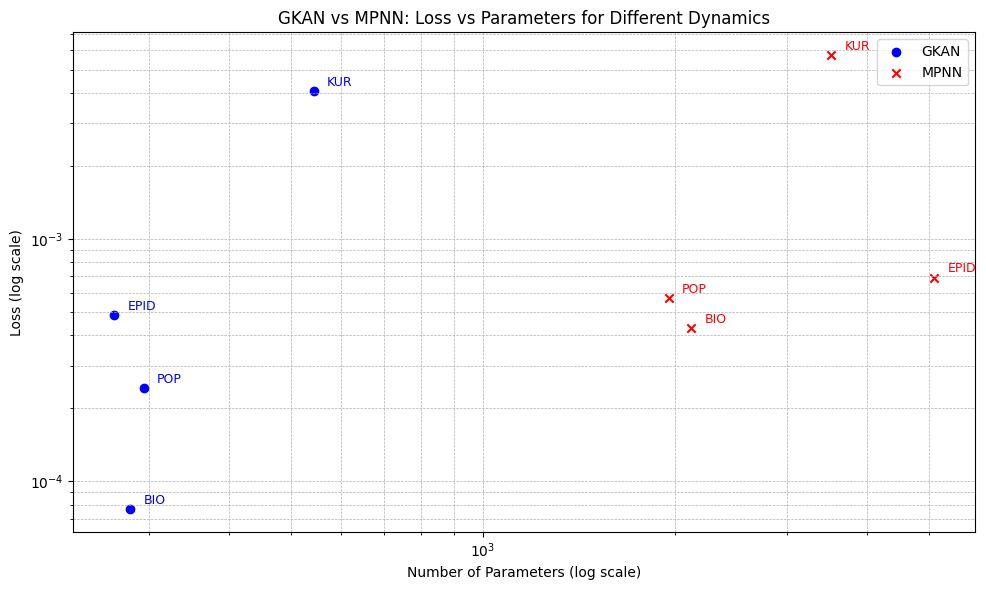

In [5]:
plt.figure(figsize=(10, 6))
for i in range(len(dynamics)):
    plt.scatter(gkan_params[i], gkan_losses[i], color='blue', label='GKAN' if i == 0 else "", marker='o')
    plt.scatter(mpnn_params[i], mpnn_losses[i], color='red', label='MPNN' if i == 0 else "", marker='x')
    plt.text(gkan_params[i]*1.05, gkan_losses[i]*1.05, dynamics[i], fontsize=9, color='blue')
    plt.text(mpnn_params[i]*1.05, mpnn_losses[i]*1.05, dynamics[i], fontsize=9, color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Parameters (log scale)')
plt.ylabel('Loss (log scale)')
plt.title('GKAN vs MPNN: Loss vs Parameters for Different Dynamics')
plt.legend()
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.tight_layout()
plt.show()